In [256]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd

In [257]:
output_file = 'chicken_200_symprob_0.05_rescale_3.0.h5'

simulation_data = {}
with h5py.File(output_file, 'r') as f:
    # Read global attributes
    total_chicken_population = f.attrs['total_chicken_population']
    duck_symptomatic_probability = f.attrs['duck_symptomatic_probability']
    rescale_factor = f.attrs['rescale_factor']

    # Iterate over all other groups (simulations)
    for sim_name in f:
        # Access the simulation group
        sim_group = f[sim_name]
           
        # Check for time and state datasets
        if "time" in sim_group and "state" in sim_group:
            t = sim_group["time"][:]
            y = sim_group["state"][:]
            simulation_data[sim_name] = {
                "time": t,
                "state": y
            }
        else:
            print(f"Warning: Missin6]g 'time' or 'state' in {sim_name}")


In [258]:
def if_outbreak(t, y, outbreak_threshold=10):
    return np.sum(y[-1, :, :, 5:]) >= outbreak_threshold

In [259]:
def find_peak_time(t, y):
    tot_size = np.sum(y[:, :, :, 3:5], axis=(1, 2, 3))
    return t[np.argmax(tot_size)]


In [260]:
def passive_surveillance(t, y, alert_threshold=5):
    for time in range(1, int(np.ceil(t[-1])), 1):
        if np.sum(y[np.searchsorted(t, time), :, :, 6]) - np.sum(y[np.searchsorted(t, time-1), :, :, 6]) >= alert_threshold:
            return float(time)
    return None

In [261]:
def enhanced_passive_surveillance(t, y, interval=7, starting_time = 0, chicken=True, duck=True):
    checking_times = np.arange(starting_time, t[-1], interval)
    for time in checking_times:
        cases = int(chicken) * np.sum(y[np.searchsorted(t, time), :, [0,2], 6]) + int(duck) * np.sum(y[np.searchsorted(t, time), :, [1,3], 6])  
        if cases > 0:
            return time
    return None
    

In [262]:
def active_surveillance(t, y, interval=7, starting_time = 0, no_test = 10, chicken=True, duck=True):
    checking_times = np.arange(starting_time, t[-1], interval)
    for time in checking_times:
        cases = int(chicken) * np.sum(y[np.searchsorted(t, time), :, [0,2], 3:5]) + int(duck) * np.sum(y[np.searchsorted(t, time), :, [1,3], 3:5])
        popul_to_test = int(chicken) * total_chicken_population + int(duck) * (200 - total_chicken_population)
        test_array = np.array([1] * int(cases) + [0] * int(popul_to_test - cases))
        if np.sum(np.random.choice(test_array, size=no_test, replace=False)) >= 1:
            return time
    return None

In [263]:
# Initialize a list to store results
results = []

for sim_name, data in simulation_data.items():
    interval = 7
    starting_time = np.random.randint(0, interval)
    
    # Compute the necessary values
    outbreak = if_outbreak(data["time"], data["state"])
    peak_time = find_peak_time(data["time"], data["state"])
    pas = passive_surveillance(data["time"], data["state"])
    eps = enhanced_passive_surveillance(data["time"], data["state"], interval=interval, starting_time=starting_time, chicken=True, duck=True)
    acs = active_surveillance(data["time"], data["state"], interval=interval, starting_time=starting_time, no_test=10, chicken=True, duck=True)

    # Append the computed values to the list
    results.append([sim_name, outbreak, peak_time, pas, eps, acs])

# Create a DataFrame in one go
df = pd.DataFrame(results, columns=["simulation", "outbreak", "peak_time", 
                                    "passive_surveillance", "enhanced_passive_surveillance", 
                                    "active_surveillance"])


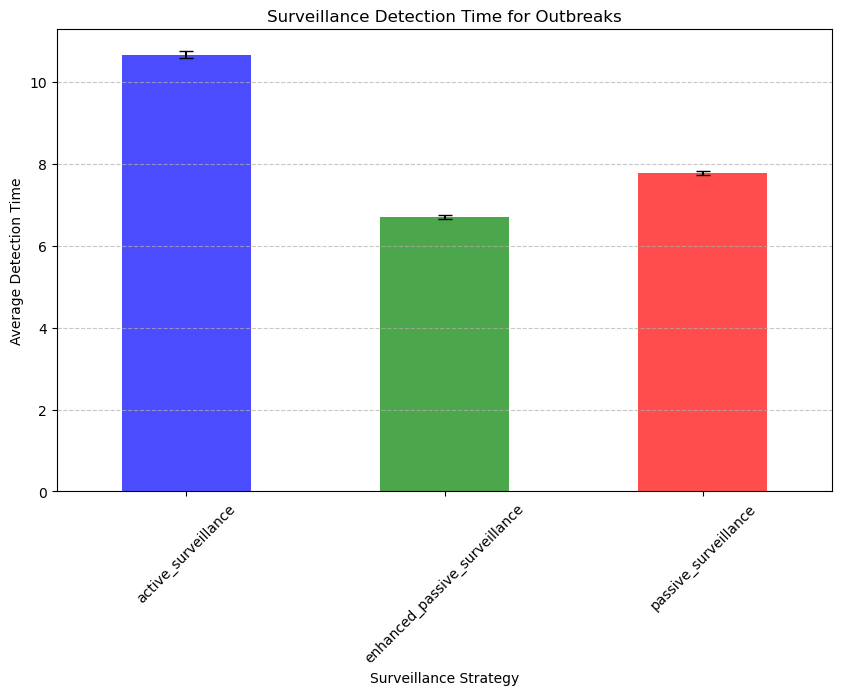

In [264]:

# Filter for outbreak cases
df_outbreaks = df[df["outbreak"] == True].copy()

if df_outbreaks.empty:
    print("No outbreaks detected. No plot will be generated.")
else:
    # Melt the DataFrame to reshape for plotting
    df_melted = df_outbreaks.melt(id_vars=["simulation"], 
                                  value_vars=["active_surveillance", "enhanced_passive_surveillance", "passive_surveillance"],
                                  var_name="Surveillance Strategy", 
                                  value_name="Detection Time")

    # Drop NaNs
    df_melted = df_melted.dropna()

    # Compute mean and standard error (SE) for error bars
    means = df_melted.groupby("Surveillance Strategy")["Detection Time"].mean()
    std_errors = df_melted.groupby("Surveillance Strategy")["Detection Time"].sem()  # Standard error

    # Plot with error bars
    plt.figure(figsize=(10, 6))
    ax = means.plot(kind="bar", yerr=std_errors, capsize=5, color=["blue", "green", "red"], alpha=0.7)

    # Labels and title
    plt.xlabel("Surveillance Strategy")
    plt.ylabel("Average Detection Time")
    plt.title("Surveillance Detection Time for Outbreaks")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()


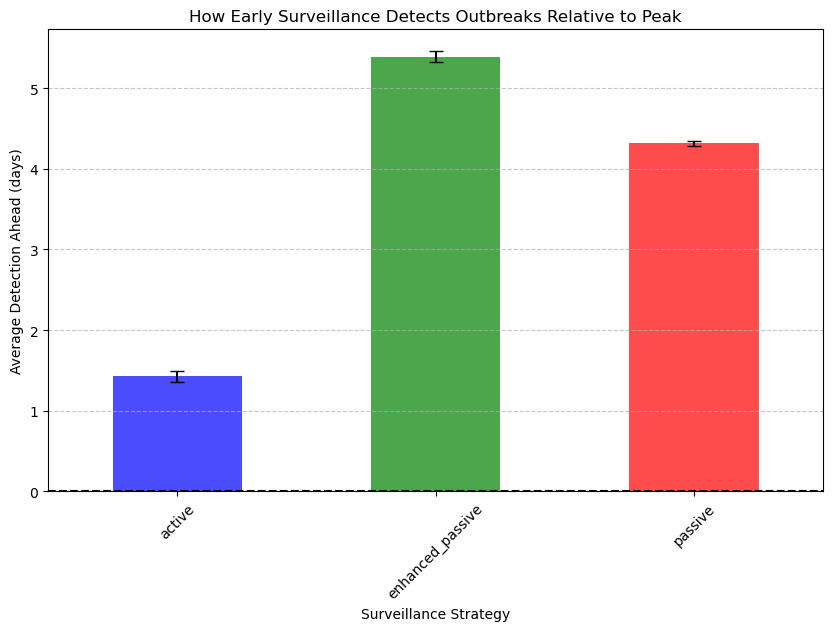

In [266]:
# Filter for outbreak cases
df_outbreaks = df[df["outbreak"] == True].copy()

if df_outbreaks.empty:
    print("No outbreaks detected. No plot will be generated.")
else:
    # Compute ahead time for each surveillance method (positive means detected before peak)
    df_outbreaks["passive"] = df_outbreaks["peak_time"] - df_outbreaks["passive_surveillance"]
    df_outbreaks["enhanced_passive"] = df_outbreaks["peak_time"] - df_outbreaks["enhanced_passive_surveillance"]
    df_outbreaks["active"] = df_outbreaks["peak_time"] - df_outbreaks["active_surveillance"]

    # Drop NaNs before melting
    df_melted = df_outbreaks.melt(id_vars=["simulation"], 
                                  value_vars=["active", "enhanced_passive", "passive"],
                                  var_name="Surveillance Strategy", 
                                  value_name="Detection Ahead (days)").dropna()

    # Compute mean and standard error (SE) for error bars
    means = df_melted.groupby("Surveillance Strategy")["Detection Ahead (days)"].mean()
    std_errors = df_melted.groupby("Surveillance Strategy")["Detection Ahead (days)"].sem()  # Standard error

    # Plot with error bars
    plt.figure(figsize=(10, 6))
    ax = means.plot(kind="bar", yerr=std_errors, capsize=5, color=["blue", "green", "red"], alpha=0.7)

    # Labels and title
    plt.xlabel("Surveillance Strategy")
    plt.ylabel("Average Detection Ahead (days)")
    plt.title("How Early Surveillance Detects Outbreaks Relative to Peak")
    plt.xticks(rotation=45)
    plt.axhline(0, color="black", linestyle="--")  # Reference line at 0
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()


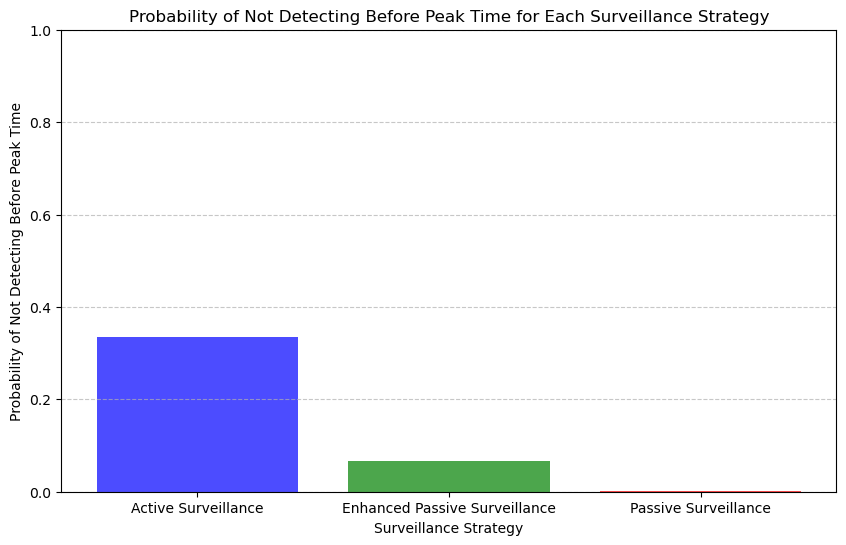

In [268]:


# Assuming 'df' contains the full dataset
# Filter out simulations where outbreak is False
df_outbreaks = df[df["outbreak"] == True].copy()

# Create a boolean column for each surveillance strategy
df_outbreaks["passive_after_peak"] = df_outbreaks["passive_surveillance"] >= df_outbreaks["peak_time"]
df_outbreaks["enhanced_passive_after_peak"] = df_outbreaks["enhanced_passive_surveillance"] >= df_outbreaks["peak_time"]
df_outbreaks["active_after_peak"] = df_outbreaks["active_surveillance"] >= df_outbreaks["peak_time"]

# Calculate the probability (fraction of True values) for each strategy
probabilities = {
    "Active Surveillance": df_outbreaks["active_after_peak"].mean(),
    "Enhanced Passive Surveillance": df_outbreaks["enhanced_passive_after_peak"].mean(),
    "Passive Surveillance": df_outbreaks["passive_after_peak"].mean()
}

# Plot the probabilities
plt.figure(figsize=(10, 6))
plt.bar(probabilities.keys(), probabilities.values(), color=["blue", "green", "red"], alpha=0.7)

# Labels and title
plt.xlabel("Surveillance Strategy")
plt.ylabel("Probability of Not Detecting Before Peak Time")
plt.title("Probability of Not Detecting Before Peak Time for Each Surveillance Strategy")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [253]:
# for sim_name in simulation_data:
#     t = simulation_data[sim_name]["time"]
#     y = simulation_data[sim_name]["state"]
#     plt.plot(t, np.sum(y[:, 0, 0:2, 3], axis=1) + np.sum(y[:, 0, 0:2, 4], axis=1), color='blue', alpha=0.5)
# plt.xlabel('Time (days)')
# plt.ylabel('Number of infected birds')
# plt.grid(True)
# plt.show()


In [254]:
# for sim_name in simulation_data:
#     t = simulation_data[sim_name]["time"]
#     y = simulation_data[sim_name]["state"]
#     plt.plot(t, np.sum(y[:, 0, 0:2, 6], axis=1), color='blue', alpha=0.5)
# plt.xlabel('Time (days)')
# plt.ylabel('Number of dead birds')
# plt.grid(True)
# plt.show()
